In [44]:
from __future__ import print_function

import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

save_dir = os.path.join(os.getcwd(), 'saved_models')

from IPython.display import clear_output
from keras_helper import PlotProgress

%matplotlib inline

In [45]:
num_classes = 6

In [46]:
def get_confusion_matrix(Y, Y_hat):
    report = classification_report(
        y_true=Y.argmax(axis=1),
        y_pred=Y_hat.argmax(axis=1),
        labels=list(label_mapping.keys()),
        target_names=list(label_mapping.values())
    )
    return report

In [47]:
class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entities=['loss']):
        self.entities = entities
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = {}
        self.val_losses = {}
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        
        for entity in self.entities:
            self.losses.update({
                '{}'.format(entity) : self.losses.get('{}'.format(entity), list()) + [logs.get('{}'.format(entity))]
            })
            self.val_losses.update({
                'val_{}'.format(entity) : self.val_losses.get('val_{}'.format(entity), list()) + [logs.get('val_{}'.format(entity))]
            })
        self.i += 1
        
        clear_output(wait=True)
        ncol = 2
        nrow = int(len(self.entities) / ncol) + 1
        plt.figure(figsize=(12, 8))
        
        for idx, entity in enumerate(self.entities):
            plt.subplot(nrow, ncol, idx + 1)
            plt.plot(self.x, self.losses.get("{}".format(entity)), label="{}".format(entity))
            plt.plot(self.x, self.val_losses.get("val_{}".format(entity)), label="val_{}".format(entity))
            plt.xlabel('epoch')
            plt.title(entity)
            plt.legend()
        plt.show();

In [5]:
body_acc_x_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_x_train.txt', sep='\s+', header=None)
body_acc_y_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_y_train.txt', sep='\s+', header=None)
body_acc_z_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_z_train.txt', sep='\s+', header=None)

total_acc_x_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_x_train.txt', sep='\s+', header=None)
total_acc_y_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_y_train.txt', sep='\s+', header=None)
total_acc_z_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_z_train.txt', sep='\s+', header=None)

body_gyro_x_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_x_train.txt', sep='\s+', header=None)
body_gyro_y_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_y_train.txt', sep='\s+', header=None)
body_gyro_z_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_z_train.txt', sep='\s+', header=None)

y_train = pd.read_csv('../data/har/train/y_train.txt', sep='\s+', header=None).values

In [6]:
label_info = pd.read_csv('../data/har/activity_labels.txt', sep='\s+', header=None)
label_mapping = dict()

for index, row_data in label_info.iterrows():
    label_mapping.update({row_data[0] -1 : row_data[1]})

In [7]:
def get_spectogram(x):
    frequencies, times, spectogram = signal.spectrogram(
        x,
        fs = 50,
        window = 'boxcar',
        nperseg = 32,
        noverlap = 8,
    )
    return spectogram
    
spects_list = [body_acc_train.apply(get_spectogram, axis=1) for body_acc_train in 
                              [body_acc_x_train, body_acc_y_train, body_acc_z_train,
                               total_acc_x_train, total_acc_y_train, total_acc_z_train,
                               body_gyro_x_train, body_gyro_y_train, body_gyro_z_train,]]

In [8]:
X_train = np.stack([np.array([elem for elem in component.values]) for component in spects_list], axis=-1)

In [9]:
encoder = OneHotEncoder(categories='auto')
Y_train = encoder.fit_transform(y_train).toarray()

In [10]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')

In [11]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                      Y_train,
                                                      test_size=0.2,
                                                      random_state=123)

In [12]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((5881, 17, 5, 9), (5881, 6), (1471, 17, 5, 9), (1471, 6))

In [38]:
kernel_shape = (3, 3)
max_pool_shape = (2, 2)
rate = 0.33

input_sample_size = X_train.shape[1:]

model = Sequential()
model.add(Conv2D(64, kernel_shape, padding='same',
                 input_shape=input_sample_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = max_pool_shape, padding='same'))
model.add(Dropout(rate))


model.add(Conv2D(32, kernel_shape, padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = max_pool_shape, padding='same'))
model.add(Dropout(rate))

model.add(Conv2D(8, kernel_shape, padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = max_pool_shape, padding='same'))
model.add(Dropout(rate))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [39]:
# kernel_shape = (3, 3)
# max_pool_shape = (2, 2)
# rate = 0.3

# input_sample_size = X_train.shape[1:]

# model = Sequential()
# model.add(Conv2D(16, kernel_shape, padding='same',
#                  input_shape=input_sample_size))
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size = max_pool_shape, strides=1, padding='same'))
# # model.add(Dropout(rate))

# # model.add(Conv2D(32, kernel_shape, padding='same'))
# # model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size = max_pool_shape, strides=1, padding='same'))
# # model.add(Dropout(rate))

# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(rate))

# model.add(Dense(32))
# model.add(Activation('relu'))
# model.add(Dropout(rate))

# model.add(Dense(32))
# model.add(Activation('relu'))
# model.add(Dropout(rate))

# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 17, 5, 64)         5248      
_________________________________________________________________
activation_20 (Activation)   (None, 17, 5, 64)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 3, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 9, 3, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 3, 32)          18464     
_________________________________________________________________
activation_21 (Activation)   (None, 9, 3, 32)          0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 2, 32)          0         
__________

In [41]:
opt = keras.optimizers.rmsprop(lr=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



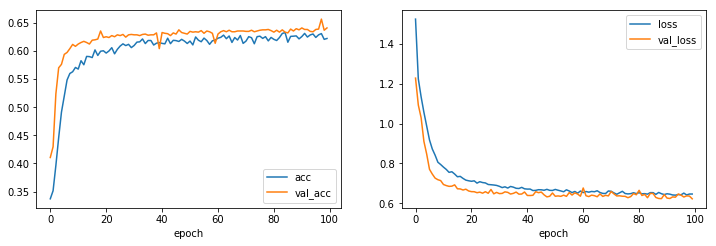

CPU times: user 2min 38s, sys: 57.8 s, total: 3min 36s
Wall time: 1min 56s


In [42]:
%%time
batch_size = 64
epochs = 100

plot_progress = PlotProgress(entities=['acc', 'loss'])

save_path = './keras-saves/_latest.ckpt'
try:
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_valid, Y_valid),
              callbacks=[plot_progress],
              shuffle=True,
         )
except KeyboardInterrupt:
#     model.save(save_path)
    print('\nOutput saved to: "{}./*"'.format(save_path))

In [48]:
label_mapping, set(model.predict(X_train).argmax(axis=1))

({0: 'WALKING',
  1: 'WALKING_UPSTAIRS',
  2: 'WALKING_DOWNSTAIRS',
  3: 'SITTING',
  4: 'STANDING',
  5: 'LAYING'},
 {0, 1, 2, 4, 5})

In [49]:
set(model.predict(X_valid).argmax(axis=1))

{0, 1, 2, 4, 5}

In [ ]:
layer_name = 'conv2d_1'

In [ ]:
import conv_filter_visualization as filter_viz

In [ ]:
from importlib import reload
reload(filter_viz)

In [ ]:
filter_viz.visualize_layer(model, layer_name)

In [ ]:
plot_model(model, show_shapes=True)

In [62]:
np.reshape(body_acc_x_train[:1].values, -1)

(128,)

Text(0, 0.5, 'amplitude')

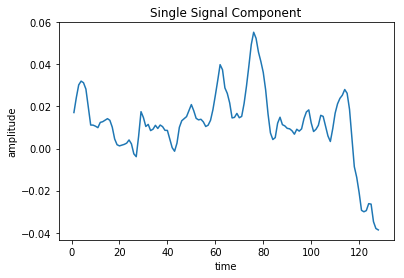

In [80]:
plt.plot(np.linspace(1, 128, num=128), np.reshape(body_gyro_x_train.iloc[1, :].values, -1))
# plt.plot(np.linspace(1, 128, num=128), np.reshape(body_gyro_y_train.iloc[1, :].values, -1), label="y gyro")
# plt.plot(np.linspace(1, 128, num=128), np.reshape(body_gyro_z_train.iloc[2, :].values, -1), label="z gyro")
plt.title('Single Signal Component')
# plt.legend()

plt.xlabel('time')
plt.ylabel('amplitude')

In [ ]:
X_train.shape, Y_train.shape

In [51]:
print("Train Confusion Matrix\n", get_confusion_matrix(Y_train, model.predict(X_train)))
print("Validation Confusion Matrix\n", get_confusion_matrix(Y_valid, model.predict(X_valid)))

Train Confusion Matrix
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       993
  WALKING_UPSTAIRS       1.00      1.00      1.00       847
WALKING_DOWNSTAIRS       1.00      1.00      1.00       778
           SITTING       0.00      0.00      0.00      1042
          STANDING       0.54      0.07      0.13      1096
            LAYING       0.35      0.96      0.51      1125

         micro avg       0.64      0.64      0.64      5881
         macro avg       0.65      0.67      0.61      5881
      weighted avg       0.61      0.64      0.57      5881

Validation Confusion Matrix
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       233
  WALKING_UPSTAIRS       1.00      0.98      0.99       226
WALKING_DOWNSTAIRS       0.98      1.00      0.99       208
           SITTING       0.00      0.00      0.00       244
          STANDING       0.42      0.06    

In [113]:
spects = body_gyro_x_train.apply(lambda x :
    signal.spectrogram(
            x,
            fs = 50,
            window = 'boxcar',
            nperseg = 32,
            noverlap = 8,
        )
    , axis = 1
)

In [114]:
grouped_mean_spectrogram = spects.groupby(y_train.reshape(-1)).apply(lambda group: np.mean([specg for frequencies, times, specg in group], axis=0))

Text(0.5, 1.0, 'Spectrogram')

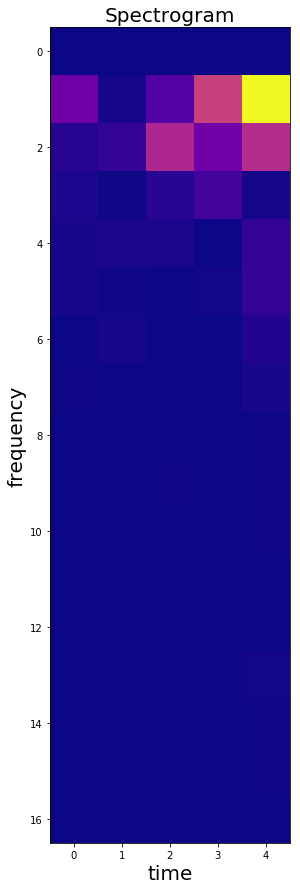

In [125]:
plt.figure(figsize=(9, 15))
plt.imshow(spects[1][2], cmap='plasma')
plt.xlabel('time', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('Spectrogram', fontsize=20)

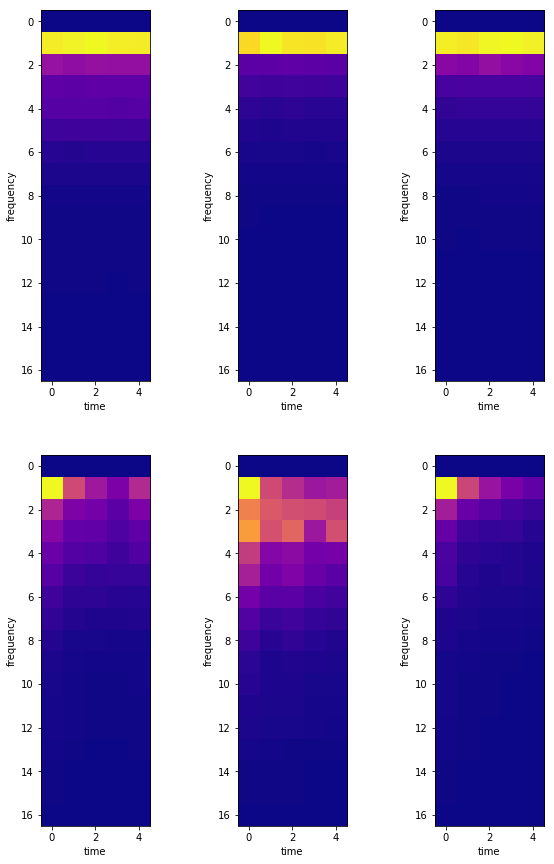

In [94]:
plt.figure(figsize=(10, 15))
for i in grouped_mean_spectrogram.index:
    plt.subplot(2, 3, i)
#     plt.yticks(frequencies)
    plt.imshow(grouped_mean_spectrogram[i], cmap='plasma')
    plt.title(label_mapping.get(i-1))
    plt.xlabel('time')
    plt.ylabel('frequency')

In [ ]:
plt.figure(figsize=(20, 20))

sample = 10
cat = 4

for i, (freqs, times, spec) in enumerate(spects.groupby(y_train.reshape(-1)).get_group(cat)[:sample]):
    plt.subplot(3, 4, i+1)
    plt.yticks(freqs)
    plt.imshow(spec, cmap='plasma')
    plt.title(label_mapping.get(cat))
